In [1]:
from itertools import cycle

import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d, convolve
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import MNIST
# from torchvision import transforms
from IPython.display import clear_output
from typing import Tuple, List
from tqdm import *
%matplotlib inline

/home/ilya20/docomets/MusicTranscription/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import note_seq
import bokeh
import librosa.display

from src.features.build_features import detokenize, join_splitted_notes
from src.entities.audio_params import AudioParams
from src.entities.dataset_params import DatasetParams
from src.data.make_dataset import WavMidiDataset, AudioDataset
from src.models.metrics import accuracy

/home/ilya20/docomets/MusicTranscription/.venv/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
SAMPLE_RATE = 44100
FRAME_LENGTH = 8192
OVERLAPPING = 16


audio_params = AudioParams(
    sample_rate=SAMPLE_RATE,
    frame_length=FRAME_LENGTH,
    n_mels=512,
    fmin=8,
    fmax=12500,
    window="taylor"
)
train_params = DatasetParams(
    root_path="/mnt/d/Datasets/maestro-v3.0.0/",
    metadata="maestro-v3.0.0.csv",
    years_list=[2017],
    split="train",
    audio_params=audio_params,
    feature_size=3,
    overlapping=OVERLAPPING,
)
test_params = DatasetParams(
    root_path="/mnt/d/Datasets/maestro-v3.0.0/",
    metadata="maestro-v3.0.0.csv",
    years_list=[2017],
    split="test",
    audio_params=audio_params,
    feature_size=3,
    overlapping=OVERLAPPING,
)

gpu = True

device = torch.device("cuda" if torch.cuda.is_available() and gpu else "cpu")
device

device(type='cuda')

In [4]:
train_ds = WavMidiDataset(train_params)
test_ds = WavMidiDataset(test_params)

In [5]:
len(train_ds), len(test_ds)

(106, 18)

In [6]:
# frames, notes, times = train_ds[37]
# train_audio_ds = AudioDataset(frames, notes)
# train_loader = DataLoader(train_audio_ds, 1000)

# frames, notes, times = test_ds[7]
# test_audio_ds = AudioDataset(frames, notes)
# test_loader = DataLoader(test_audio_ds, 1000)

# train_loader = DataLoader(train_ds, 1)
# test_loader = DataLoader(test_ds, 1)

In [7]:
# loss = nn.MultiLabelMarginLoss()
# x = torch.FloatTensor([[0.1, 0.9, 0.1, 1]])
# # for target y, only consider labels 3 and 0, not after label -1
# y = torch.LongTensor([[1, 3, -1, -1]])
# # 0.25 * ((1-(0.1-0.2)) + (1-(0.1-0.4)) + (1-(0.8-0.2)) + (1-(0.8-0.4)))
# loss(x, y)

In [8]:
# frames, notes, _ = train_ds[10]
# audio_ds = AudioDataset(frames, notes)
# audio_loader = DataLoader(audio_ds, 15, )

In [9]:
# i = 0
# for X, pitch, vel, notes_count in audio_loader:
#     if i > 100:
#         break
#     i += 1
# print(X.shape)
# print(pitch)
# print(vel)
# print(notes_count)

In [11]:
def train(network, epochs: int, learning_rate=1e-4, batch_size=100):
    loss_multi = nn.MultiLabelMarginLoss()
    loss_mse = nn.MSELoss()
    
    optimizer_base = torch.optim.Adam(network.base.parameters(), lr=learning_rate)
    optimizer_vel = torch.optim.Adam(network.velocity_layer.parameters(), lr=learning_rate)
    optimizer_count = torch.optim.Adam(network.count_layer.parameters(), lr=learning_rate)
    train_loss_epochs = []
    train_loss_count_epochs = []
    train_loss_vel_epochs = []

    test_loss_epochs = []
    test_loss_count_epochs = []
    test_loss_vel_epochs = []
    
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            test_cycle = cycle(test_ds)
            for i, item in enumerate(zip(train_ds, test_cycle)):
                # train
                losses_pitch = []
                losses_count = []
                losses_vel = []
                accuracies_pitch = []

                frames, notes, _ = item[0]
                train_audio = AudioDataset(frames, notes)
                train_audio_loader = DataLoader(train_audio, batch_size)
                audio_iter = tqdm(train_audio_loader)
                for X, pitch, vel, notes_count in audio_iter:
                    X = X.to(device)
                    pitch = pitch.to(device)
                    vel = vel.to(device).float()
                    notes_count = notes_count.to(device).float()

                    network.zero_grad()
                    pred_pitch, pred_vel, pred_count = network.forward(X)

                    loss_batch_pitch = loss_multi(pred_pitch, pitch)
                    loss_batch_vel = loss_mse(pred_vel.squeeze(), vel)
                    loss_batch_count = loss_mse(pred_count.squeeze(), notes_count)
                    # loss = loss_batch_pitch + loss_batch_vel + loss_batch_count
                    # loss = loss_batch_pitch

                    losses_pitch.append(loss_batch_pitch.item())
                    losses_vel.append(loss_batch_vel.item())
                    losses_count.append(loss_batch_count.item())
                    
                    # loss.backward()
                    loss_batch_pitch.backward()
                    loss_batch_vel.backward()
                    loss_batch_count.backward()
                    optimizer_base.step()
                    optimizer_vel.step()
                    optimizer_count.step()

                    audio_iter.set_description("TRAIN: Epoch: %04d, Audio: %04d/%04d, Pitch Loss: %.4f, Vel Loss: %.4f, Count Loss: %.4f"  %(epoch, i, len(train_ds), loss_batch_pitch, loss_batch_vel, loss_batch_count))
                    accuracies_pitch.append(accuracy(
                        pred_pitch.cpu().detach().numpy(),
                        pitch.cpu().detach().numpy(),
                        pred_count.squeeze().int().cpu().detach().numpy()
                    ))

                train_loss_epochs.append(np.mean(losses_pitch))
                train_loss_vel_epochs.append(np.mean(losses_vel))
                train_loss_count_epochs.append(np.mean(losses_count))
                train_accuracy_epochs.append(np.mean(accuracies_pitch))

                # test
                losses_pitch = []
                losses_count = []
                losses_vel = []
                accuracies_pitch = []
                accuracies_vel = []

                frames, notes, _ = item[1]
                test_audio = AudioDataset(frames, notes)
                test_audio_loader = DataLoader(test_audio, batch_size)
                audio_iter = tqdm(test_audio_loader)
                for X, pitch, vel, notes_count in audio_iter:
                    X = X.to(device)
                    pitch = pitch.to(device)
                    vel = vel.to(device).float()
                    notes_count = notes_count.to(device)

                    pred_pitch, pred_vel, pred_count = network.forward(X)

                    loss_batch_pitch = loss_multi(pred_pitch, pitch)
                    loss_batch_vel = loss_mse(pred_vel.squeeze(), vel)
                    loss_batch_count = loss_mse(pred_count.squeeze(), notes_count)
                    
                    losses_pitch.append(loss_batch_pitch.item())
                    losses_vel.append(loss_batch_vel.item())
                    losses_count.append(loss_batch_count.item())

                    audio_iter.set_description("TEST: Epoch: %04d, Audio: %04d/%04d, Pitch Loss: %.4f, Vel Loss: %.4f, Count Loss: %.4f"  %(epoch, i, len(train_ds), loss_batch_pitch, loss_batch_vel, loss_batch_count))
                    accuracies_pitch.append(accuracy(
                        pred_pitch.cpu().detach().numpy(),
                        pitch.cpu().detach().numpy(),
                        pred_count.squeeze().int().cpu().detach().numpy()
                    ))

                test_loss_epochs.append(np.mean(losses_pitch))
                test_loss_vel_epochs.append(np.mean(losses_vel))
                test_loss_count_epochs.append(np.mean(losses_count))
                test_accuracy_epochs.append(np.mean(accuracies_pitch))
                
                # output
                clear_output(True)
                print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tMSE vel: {3:.3f}/{4:.3f}\tMSE count: {5:.3f}/{6:.3f}\tAccuracy: {7:.3f}/{8:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_loss_vel_epochs[-1], test_loss_vel_epochs[-1],
                            train_loss_count_epochs[-1], test_loss_count_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]
                        ))
                plt.figure(figsize=(24, 10))
                plt.subplot(2, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Audio tracks', fontsize=16)
                plt.ylabel('MML Loss (Pitch)', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(2, 2, 2)
                plt.plot(train_loss_vel_epochs, label='Train')
                plt.plot(test_loss_vel_epochs, label='Test')
                plt.xlabel('Audio tracks', fontsize=16)
                plt.ylabel('MSE Loss (Velocity)', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(2, 2, 3)
                plt.plot(train_loss_count_epochs, label='Train')
                plt.plot(test_loss_count_epochs, label='Test')
                plt.xlabel('Audio tracks', fontsize=16)
                plt.ylabel('MSE Loss (Count)', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(2, 2, 4)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Audio tracks', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
    except KeyboardInterrupt:
        pass

In [12]:
class Resnet3(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.conv_stack1 = nn.ModuleList([
                nn.Sequential(
                    nn.Conv2d(16, 16, 3, padding=1),
                    nn.Dropout(0.3),
                    nn.Tanh(),
                    nn.Conv2d(16, 16, 3, padding=1),
                    nn.Dropout(0.3),
                    nn.Tanh(),
                ) for _ in range(10)
        ])
        self.maxpool1 = nn.MaxPool2d((4, 1))

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.conv_stack2 = nn.ModuleList([
                nn.Sequential(
                    nn.Conv2d(32, 32, 3, padding=1),
                    nn.Dropout(0.3),
                    nn.Tanh(),
                    nn.Conv2d(32, 32, 3, padding=1),
                    nn.Dropout(0.3),
                    nn.Tanh(),
                ) for _ in range(5)
        ])
        self.maxpool2 = nn.MaxPool2d((1, 3))
        self.flatten = nn.Flatten()

        self.pitch_layer = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.Dropout(0.3),
            nn.Tanh(),
            nn.Linear(2048, 1024),
            nn.Dropout(0.3),
            nn.Tanh(),
            nn.Linear(1024, 129),
            nn.LogSoftmax(dim=1)
        )

        self.velocity_layer = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.Dropout(0.3),
            nn.Tanh(),
            nn.Linear(2048, 1),
        )
        self.count_layer = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.Dropout(0.3),
            nn.Tanh(),
            nn.Linear(1024, 1),
        )
        self.base = nn.ModuleList([
            self.conv_layer1,
            self.conv_stack1,
            self.maxpool1,
            self.conv_layer2,
            self.conv_stack2,
            self.maxpool2,
            self.pitch_layer
        ])

    def forward(self, x: torch.Tensor):
        x = self.conv_layer1(x)
        for layer in self.conv_stack1:
            x = layer(x) + x
        x = self.maxpool1(x)

        x = self.conv_layer2(x)
        for layer in self.conv_stack2:
            x = layer(x) + x
        x = self.maxpool2(x)
        x = self.flatten(x)

        pitch = self.pitch_layer(x)
        # with torch.no_grad():
        velocity = self.velocity_layer(x.clone().detach())
        notes_count = self.count_layer(x.clone().detach())
        # velocity = torch.full((x.shape[0], 1), 80, device=device, dtype=float)
        # notes_count = torch.full((x.shape[0], 1), 5, device=device, dtype=float)
        return pitch, velocity, notes_count

Epoch 0... (Train/Test) NLL: 0.193/0.055	MSE vel: 827.686/359.620	MSE count: 2.723/1.004	Accuracy: 0.312/0.441


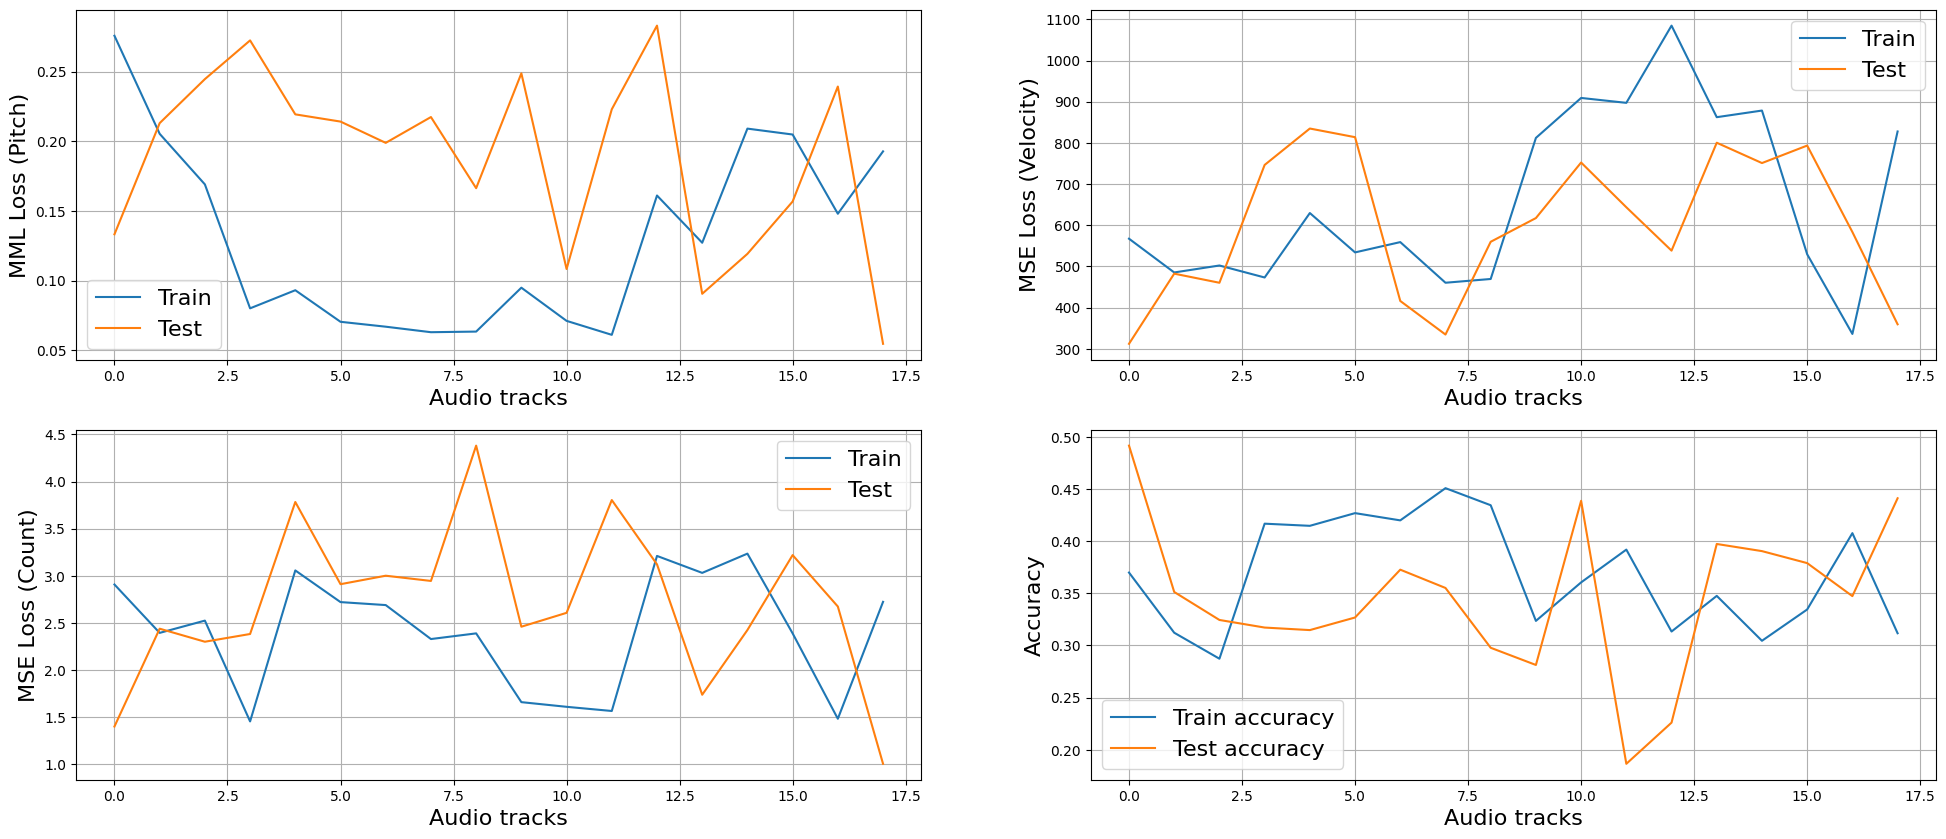

TRAIN: Epoch: 0000, Audio: 0018/0106, Pitch Loss: 0.1234, Vel Loss: 1161.0648, Count Loss: 3.6676:   1%|▏         | 2/159 [00:00<00:34,  4.53it/s]

[128  81  73  53  95  65  93  61  82  67  72  85  91  79  64  80  71  59
  97  89  56  83  86  74  68  84  62  87  63  54  94  57  55  92  78  66
  76  58  90  75  96  88 100  99  70 102  69  47  44  52  98  45  77  34
  50  60  35  37  46  48  36  32  33  41 101  38  49  28  39  43  26  51
  40  29 103 105  30  23  31  42 104  24  22  27  25  19 109 116  21   4
   7   8  16  10 117 108 127   2 115 113 120  18  20  17   5 118  14   3
  13 121  15  11 114 110   1 119 126 106   6 112 123   9  12   0 107 124
 125 122]
[128  89  73  97  55  95  65  82  67  53  80  79  85  56  71  61  83  87
  75  64  78  68  92  99  74  62  58  44  57  63  77  54  91  94  72  90
  86  76  70  66  88  46  93  59  96  81  45 100  49 102  84  98  50  36
  47  60  48  37  39  51  34  69 101  38  52  35  33  26  41  42  28  32
  27  43  23  29  31 104 103  30 105  24  40  25  22  21 110   3  14 113
   7  18  13 118 121   4  17  16  19 117 119  10   2   6   5 123 120   8
 124  20 106 109 111   1   9 114   0 112 

TRAIN: Epoch: 0000, Audio: 0018/0106, Pitch Loss: 0.1210, Vel Loss: 855.6764, Count Loss: 3.0595:   1%|▏         | 2/159 [00:00<00:48,  3.27it/s] 


In [13]:
net = Resnet3().to(device)
net.load_state_dict(torch.load("../models/model.ptx"))
train(net, 20, 1e-4, 100)

In [15]:
torch.save(net.state_dict(), "../models/model.ptx")

In [16]:
net = Resnet3().to(device)
net.load_state_dict(torch.load("../models/model.ptx"))

<All keys matched successfully>

In [23]:
frames, notes, times = test_ds[3]
midi_filename, _ = test_ds._data.iloc[3]
ns = note_seq.midi_file_to_note_sequence(test_ds._root_path + midi_filename)

In [24]:
len(notes)

7708

In [25]:
def decode_predict(pitches, vels, pred_count):
    notes = []
    pitches = pitches.detach().cpu().numpy()
    vels = vels.detach().squeeze().cpu().numpy()
    pred_count = pred_count.detach().squeeze().cpu().numpy()
    for pitch, vel, count in zip(pitches, vels, pred_count):
        if count < 0:
            pitch = torch.IntTensor([128])
        else:
            pitch = np.argsort(pitch)[::-1][:count]
        vel = np.full_like(pitch, vel)

        notes.append((pitch, vel))
    return notes

In [26]:
audio_ds = AudioDataset(frames, notes)
audio_loader = DataLoader(audio_ds, 100)

pred_notes = []

audio_iter = tqdm(audio_loader)
for X, pitch, vel, notes_count in audio_iter:
    X = X.to(device)
    pitch = pitch.to(device)
    vel = vel.to(device)
    notes_count = notes_count.to(device)

    pred_pitch, pred_vel, pred_count = net(X)
    pred_notes.extend(decode_predict(pred_pitch, pred_vel.squeeze(), pred_count.squeeze().round().int()))

100%|██████████| 78/78 [00:03<00:00, 24.64it/s]


In [27]:
pred_notes[109]

(array([59, 71]), array([49, 49]))

In [28]:
import bokeh

fig = note_seq.plot_sequence(ns, False)
detokenized = detokenize(pred_notes, times, train_ds._frame_time)
predict = join_splitted_notes(detokenized, True, True)

fig_proc = note_seq.plot_sequence(predict, False)

fig.height = 500
fig_proc.height = 500
fig.width = 1500
fig_proc.width = 1500

bokeh.plotting.output_notebook()
bokeh.plotting.show(fig)
bokeh.plotting.show(fig_proc)

Loading BokehJS ...

In [ ]:
note_seq.note_sequence_to_midi_file(ns, "../models/predict/true.midi")
note_seq.note_sequence_to_midi_file(predict, "../models/predict/predict.midi")